In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
import seaborn as sns


/Users/alexjizdan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

X_train = train_data[:, :-1]  
y_train = train_data[:, -1]   

X_test = test_data[:, :-1]   
y_test = test_data[:, -1]     


mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std 


n_components = 110
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca shape: {X_train_pca.shape}, y_train shape: {y_train.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}, y_test shape: {y_test.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



X_train_pca shape: (10000, 110), y_train shape: (10000,)
X_test_pca shape: (5000, 110), y_test shape: (5000,)
X_train shape: (10000, 784), y_train shape: (10000,)
X_test shape: (5000, 784), y_test shape: (5000,)


In [3]:
num_classes = len(np.unique(y_train))  # Determine the number of unique classes
y_train_one_hot = np.eye(num_classes)[y_train.astype(int)]
y_test_one_hot = np.eye(num_classes)[y_test.astype(int)]

In [4]:
from sklearn.model_selection import train_test_split
# Split the training data into training and validation sets (e.g., 80% training, 20% validation)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pca, y_train_one_hot, test_size=0.2, random_state=42)


In [5]:
class FFNN_Multiclass:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, a=0.01, epochs=100, batch_size=32, dropout_rate = 0.2, debug=False):
        self.debug = debug
        self.a = a  # learning rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate

        # Initialize weights and biases
        self.wh1 = np.random.normal(0, 0.3, (input_size, hidden_size1))
        self.bh1 = np.random.normal(0, 0.3, (1, hidden_size1))

        self.wh2 = np.random.normal(0, 0.3, (hidden_size1, hidden_size2))
        self.bh2 = np.random.normal(0, 0.3, (1, hidden_size2))

        self.wo = np.random.normal(0, 0.3, (hidden_size2, output_size))
        self.bo = np.random.normal(0, 0.3, (1, output_size))

        self.loss_history = []
        
    
    @staticmethod
    def ReLU(x):
        return np.maximum(0, x)

    @staticmethod
    def ReLU_derivative(x):
        return (x > 0).astype(float)

    @staticmethod
    def SoftMax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stabilize
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    @staticmethod
    def dropout_forward(inputs, rate, training=True):
        if not training:
            return inputs, None  # No dropout during inference
        mask = np.random.binomial(1, 1 - rate, size=inputs.shape) / (1 - rate)
        return inputs * mask, mask

    @staticmethod
    def dropout_backward(dvalues, mask):
        if mask is None:  # No dropout during inference
            return dvalues
        return dvalues * mask



    def predict_proba(self, X, training=True):
        # Forward pass
        self.zh1 = X @ self.wh1 + self.bh1
        self.ah1 = self.ReLU(self.zh1)

        # Dropout after first hidden layer
        self.ah1_dropout, self.mask1 = self.dropout_forward(self.ah1, rate=self.dropout_rate, training=training)

        self.zh2 = self.ah1_dropout @ self.wh2 + self.bh2
        self.ah2 = self.ReLU(self.zh2)

        # Dropout after second hidden layer
        self.ah2_dropout, self.mask2 = self.dropout_forward(self.ah2, rate=self.dropout_rate, training=training)

        self.zo = self.ah2_dropout @ self.wo + self.bo
        self.ao = self.SoftMax(self.zo)
        return self.ao


    def backpropagate(self, X, y):
        m = X.shape[0]

            # Gradients for output layer
        dL_dzo = self.ao - y
        dzo_dwo = self.ah2_dropout
        dL_dwo = dzo_dwo.T @ dL_dzo / m
        dL_dbo = np.sum(dL_dzo, axis=0, keepdims=True) / m

        # Gradients for second hidden layer
        dzo_dah2 = self.wo
        dL_dah2 = dL_dzo @ dzo_dah2.T
        dah2_dzh2 = self.ReLU_derivative(self.zh2)
        dL_dzh2 = dL_dah2 * dah2_dzh2

        # Apply dropout mask from second hidden layer
        dL_dzh2 = self.dropout_backward(dL_dzh2, self.mask2)

        dzh2_dwh2 = self.ah1_dropout
        dL_dwh2 = dzh2_dwh2.T @ dL_dzh2 / m
        dL_dbh2 = np.sum(dL_dzh2, axis=0, keepdims=True) / m

        # Gradients for first hidden layer
        dzh2_dah1 = self.wh2
        dL_dah1 = dL_dzh2 @ dzh2_dah1.T
        dah1_dzh1 = self.ReLU_derivative(self.zh1)
        dL_dzh1 = dL_dah1 * dah1_dzh1

        # Apply dropout mask from first hidden layer
        dL_dzh1 = self.dropout_backward(dL_dzh1, self.mask1)

        dzh1_dwh1 = X
        dL_dwh1 = dzh1_dwh1.T @ dL_dzh1 / m
        dL_dbh1 = np.sum(dL_dzh1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.wh1 -= self.a * dL_dwh1
        self.bh1 -= self.a * dL_dbh1
        self.wh2 -= self.a * dL_dwh2
        self.bh2 -= self.a * dL_dbh2
        self.wo -= self.a * dL_dwo
        self.bo -= self.a * dL_dbo


    import matplotlib.pyplot as plt

    def fit(self, X_train, y_train, X_val, y_val):
        self.loss_history = []
        self.val_loss_history = []  # Track validation loss
        self.train_accuracy_history = []  # Track training accuracy
        self.val_accuracy_history = []  # Track validation accuracy
        n_samples = X_train.shape[0]

        for epoch in range(self.epochs):
            # Shuffle the data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            # Mini-batch gradient descent
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_train[i:i + self.batch_size]
                y_batch = y_train[i:i + self.batch_size]

                probabilities = self.predict_proba(X_batch)
                self.backpropagate(X_batch, y_batch)

            # Track loss for training data
            probabilities = self.predict_proba(X_train)
            loss = self.loss(y_train, probabilities)
            self.loss_history.append(loss)

            # Track accuracy for training data
            train_accuracy = self.compute_accuracy(X_train, y_train)
            self.train_accuracy_history.append(train_accuracy)

            # Track loss for validation data
            val_probabilities = self.predict_proba(X_val, training=False)  # No dropout during validation
            val_loss = self.loss(y_val, val_probabilities)
            self.val_loss_history.append(val_loss)

            # Track accuracy for validation data
            val_accuracy = self.compute_accuracy(X_val, y_val)
            self.val_accuracy_history.append(val_accuracy)

            if self.debug and epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    def compute_accuracy(self, X, y):
        predictions = self.predict(X)
        correct_predictions = np.sum(predictions == np.argmax(y, axis=1))
        accuracy = correct_predictions / len(y)
        return accuracy

    def plot_metrics(self):
        epochs = range(self.epochs)

        # Plot training and validation loss
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.loss_history, label='Train Loss')
        plt.plot(epochs, self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracy_history, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracy_history, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        plt.tight_layout()
        plt.show()




    def loss(self, y, probabilities):
        probabilities = np.clip(probabilities, 1e-9, 1.0)  # Prevent log(0)
        return -np.sum(y * np.log(probabilities)) / y.shape[0]



    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

In [6]:
# Create the model with the appropriate hyperparameters
model = FFNN_Multiclass(
    input_size=X_train_pca.shape[1],  # Number of features (after PCA)
    hidden_size1=64,                  # Hidden layer 1 neurons
    hidden_size2=32,                  # Hidden layer 2 neurons
    output_size=num_classes,          # Number of classes
    a=0.01,                           # Learning rate
    epochs=200,                       # Training epochs
    batch_size=32,                    # Mini-batch size
    dropout_rate=0.2,                 # Specify the dropout rate (e.g., 20%)
    debug=True                        # Debugging info
)

# Train the model with a validation set
model.fit(X_train_split, y_train_split, X_val_split, y_val_split)


Epoch 0, Train Loss: 1.1411, Val Loss: 0.9209, Train Accuracy: 0.5775, Val Accuracy: 0.5680
Epoch 10, Train Loss: 0.6325, Val Loss: 0.5642, Train Accuracy: 0.7529, Val Accuracy: 0.7400
Epoch 20, Train Loss: 0.5479, Val Loss: 0.4941, Train Accuracy: 0.7870, Val Accuracy: 0.7815
Epoch 30, Train Loss: 0.5051, Val Loss: 0.4738, Train Accuracy: 0.8007, Val Accuracy: 0.7920
Epoch 40, Train Loss: 0.5013, Val Loss: 0.4625, Train Accuracy: 0.8013, Val Accuracy: 0.8075
Epoch 50, Train Loss: 0.4622, Val Loss: 0.4355, Train Accuracy: 0.8174, Val Accuracy: 0.8130
Epoch 60, Train Loss: 0.4397, Val Loss: 0.4232, Train Accuracy: 0.8254, Val Accuracy: 0.8170
Epoch 70, Train Loss: 0.4342, Val Loss: 0.4248, Train Accuracy: 0.8361, Val Accuracy: 0.8110
Epoch 80, Train Loss: 0.4183, Val Loss: 0.4157, Train Accuracy: 0.8373, Val Accuracy: 0.8225
Epoch 90, Train Loss: 0.4060, Val Loss: 0.4157, Train Accuracy: 0.8406, Val Accuracy: 0.8245
Epoch 100, Train Loss: 0.3992, Val Loss: 0.4094, Train Accuracy: 0.8355

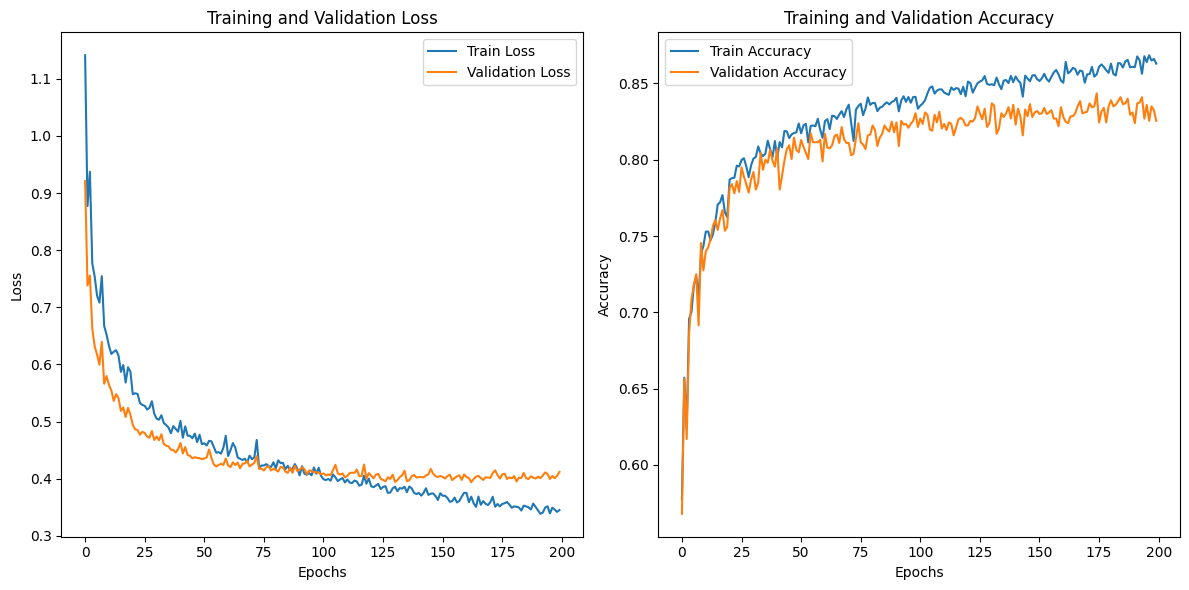

In [7]:
model.plot_metrics()

In [8]:
test_predictions = model.predict(X_test_pca)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {test_accuracy:.2%}")

Test Accuracy: 81.48%


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(report)

Confusion Matrix:
[[809   5  25  50 111]
 [  7 949  10  32   2]
 [ 19   4 872  26  79]
 [ 42  17  15 886  40]
 [197   4 176  65 558]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1000
           1       0.97      0.95      0.96      1000
           2       0.79      0.87      0.83      1000
           3       0.84      0.89      0.86      1000
           4       0.71      0.56      0.62      1000

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



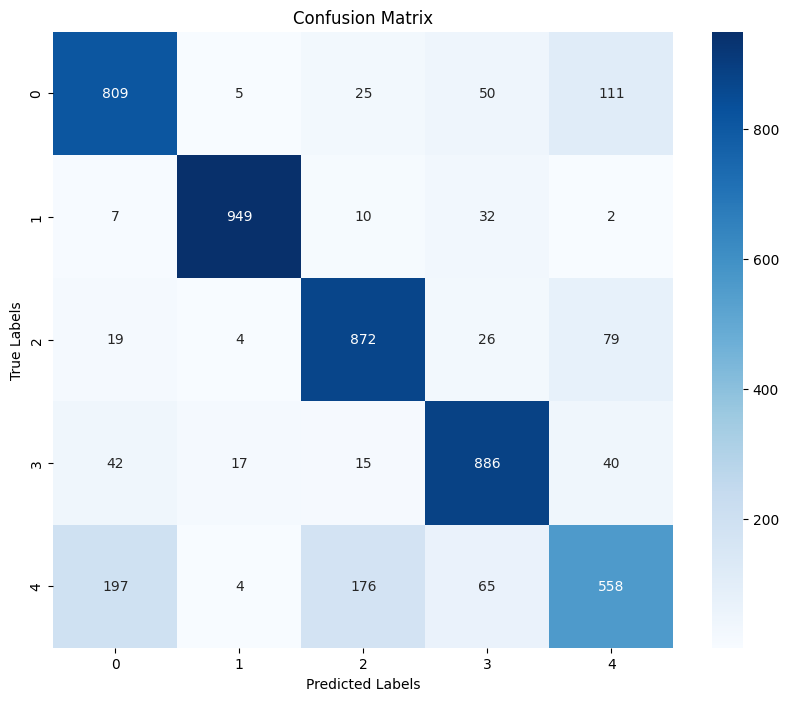

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1000
           1       0.97      0.95      0.96      1000
           2       0.79      0.87      0.83      1000
           3       0.84      0.89      0.86      1000
           4       0.71      0.56      0.62      1000

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for detailed metrics
report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(report)